### 1. 구글 드라이브 마운트

구글 코랩 환경에서 구글 드라이브를 연결하기 위한 코드입니다. 이를 통해 드라이브 내의 파일에 접근할 수 있으며, 여기서는 금융 상품 이탈률 데이터를 사용합니다.

In [9]:
# 구글 드라이브 마운트 코드 (실제 사용시에는 적절한 코드로 대체해 주세요)
# from google.colab import drive
# drive.mount('/content/drive')

### 2. 데이터 로딩 및 전처리
데이터를 로드하고 전처리하는 과정입니다. `pandas`를 사용해 CSV 파일을 읽고, 필요한 피처와 라벨을 분리합니다. 이후, 데이터를 트레이닝 세트와 테스트 세트로 나눕니다.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 데이터 로드
data = pd.read_csv('BankChurners.csv')

# 필요한 열 선택
data = data[['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Attrition_Flag']]

# 카테고리형 변수를 숫자로 매핑
data['Gender'] = data['Gender'].map({'M': 0, 'F': 1})
data['Education_Level'] = data['Education_Level'].map({'Unknown': 0, 'Uneducated': 1, 'High School': 2, 'College': 3, 'Graduate': 4, 'Post-Graduate': 5, 'Doctorate': 6})
data['Marital_Status'] = data['Marital_Status'].map({'Unknown': 0, 'Single': 1, 'Married': 2, 'Divorced': 3})
data['Income_Category'] = data['Income_Category'].map({'Unknown': 0, 'Less than $40K': 1, '$40K - $60K': 2, '$60K - $80K': 3, '$80K - $120K': 4, '$120K +': 5})
data['Card_Category'] = data['Card_Category'].map({'Blue': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3})
data['Attrition_Flag'] = data['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

# 특성과 타겟 분리
X = data.drop('Attrition_Flag', axis=1)
y = data['Attrition_Flag']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
data


,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Attrition_Flag
0,45,0,3,2,2,3,0,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,49,1,5,4,1,1,0,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,51,0,3,4,2,4,0,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,40,1,4,2,0,1,0,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,40,0,3,1,2,3,0,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,50,0,2,4,1,2,0,40,3,2,3,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0
10123,41,0,2,0,3,2,0,25,4,2,3,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,1
10124,44,1,1,2,2,1,0,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,1
10125,30,0,2,4,0,2,0,36,4,3,3,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,1


### 3. 딥러닝 모델 생성 및 훈련
`tensorflow`와 `keras`를 사용하여 딥러닝 모델을 구성하고 컴파일하는 과정입니다. 여기서는 다층 퍼셉트론 모델을 구성하고, 이진 분류를 수행합니다. `ModelCheckpoint` 콜백을 사용하여 최적의 모델을 저장합니다. 모델의 성능을 평가하기 위해 정확도, 정밀도, 재현율을 메트릭으로 사용합니다.


In [16]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint 콜백 생성
# checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

# 모델 생성
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

model.fit(X_train, y_train, epochs=1000, batch_size=256, validation_data=(X_test, y_test))
#model.fit(X_train, y_train, epochs=20, batch_size=256, validation_data=(X_test, y_test), callbacks=[checkpoint])

  


Epoch 1/1000


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7424 - loss: 123.6310 - precision_2: 0.2039 - recall_2: 0.1957 - val_accuracy: 0.7335 - val_loss: 11.6874 - val_precision_2: 0.2552 - val_recall_2: 0.3394
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7757 - loss: 7.5663 - precision_2: 0.2801 - recall_2: 0.2653 - val_accuracy: 0.7414 - val_loss: 5.0191 - val_precision_2: 0.3388 - val_recall_2: 0.6330
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 7.0185 - precision_2: 0.3128 - recall_2: 0.2425 - val_accuracy: 0.8095 - val_loss: 3.5323 - val_precision_2: 0.2190 - val_recall_2: 0.0703
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7899 - loss: 5.0191 - precision_2: 0.2769 - recall_2: 0.2095 - val_accuracy: 0.8119 - val_loss: 4.2716 - val_precision_2: 0.3893 - val_recall_2: 0.2905
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7872 - loss: 3.4860 - precision_2: 0.3298 - recall_2: 0.2937 - val_accu

### 4. 모델 성능 평가
모델의 예측 결과를 실제 라벨과 비교하여 성능을 평가하는 과정입니다. `classification_report`를 사용하여 각 클래스별 정밀도, 재현율, f1-점수 등을 출력합니다. 이는 모델의 세부 성능을 이해하는 데 도움을 줍니다.


In [17]:
# 예측
#직접 채우기
y_pred = model.predict(X_test)
predicted_labels = (y_pred > 0.5).astype(int)


# 결과 평가
print(classification_report(y_test, predicted_labels))


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1699
           1       0.85      0.71      0.77       327

    accuracy                           0.93      2026
   macro avg       0.90      0.84      0.87      2026
weighted avg       0.93      0.93      0.93      2026



### 5. 혼동 행렬
혼동 행렬을 계산하고 시각화하는 과정입니다. `matplotlib`와 `seaborn` 라이브러리를 사용하여 혼동 행렬을 그래프로 나타냅니다. 이를 통해 모델이 어떤 클래스를 어떻게 잘못 분류했는지 직관적으로 이해할 수 있습니다.


In [18]:
print(confusion_matrix(y_test, predicted_labels))

[[1657   42]
 [  95  232]]


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


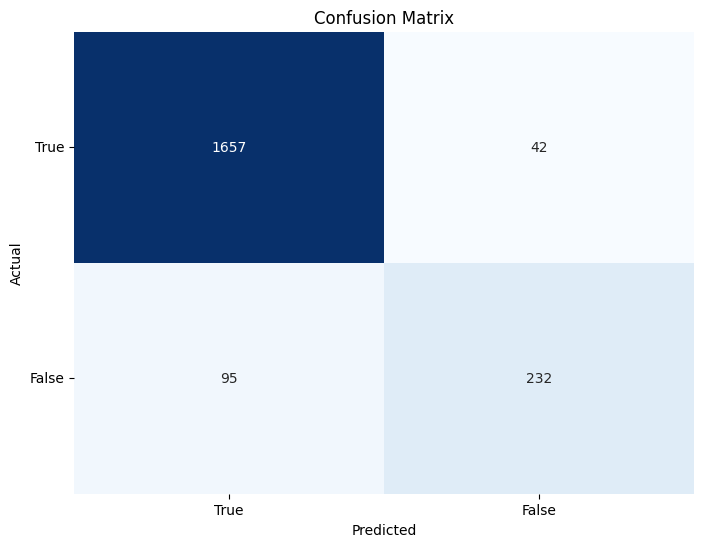

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 실제 라벨과 예측 라벨
actual = y_test
predicted = model.predict(X_test)
predicted_labels = (predicted > 0.5).astype(int)

# 혼동 행렬 계산
cm = confusion_matrix(actual, predicted_labels)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(np.arange(2) + 0.5, ['True', 'False'])
plt.yticks(np.arange(2) + 0.5, ['True', 'False'], rotation=0)
plt.title('Confusion Matrix')
plt.show()

# ROC 커브 그리기

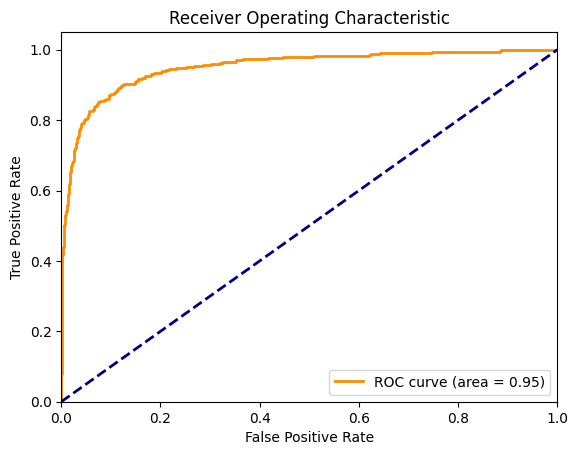

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ROC 곡선 데이터 계산
fpr, tpr, thresholds = roc_curve(actual, predicted)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()